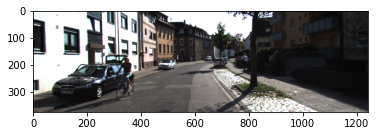

In [402]:
# import required module
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from sklearn.cluster import DBSCAN

# CHOOSE EITHER KITTI OR SUNRGBD
dataset = 'kitti'
# dataset = 'sunrgbd'

# CHOOSE A FILE
f = '/multiview/3d-count/Kitti/training/label_2/004483.txt' # there is overlapping objects of mixed classes
# f = '/multiview/3d-count/Kitti/training/label_2/000008.txt' # there is overlapping objects of the same class
# f = '/multiview/3d-count/Kitti/training/label_2/004752.txt'

# f = '/multiview/3d-count/OFFICIAL_SUNRGBD/sunrgbd/sunrgbd_trainval/label/003164.txt'
# f = '/multiview/3d-count/OFFICIAL_SUNRGBD/sunrgbd/sunrgbd_trainval/label/003165.txt'

# simplify the following code:
if dataset == 'kitti':
    label_directory = '/multiview/3d-count/Kitti/training/label_2'
    image_directory = '/multiview/3d-count/Kitti/training/image_2'
    real_classes = ['Car', 'Pedestrian', 'Cyclist']
    color_dict = {'Car': 'blue',
                'Pedestrian': 'red',
                'Cyclist': 'green'}
elif dataset == 'sunrgbd':
    image_directory = '/multiview/3d-count/OFFICIAL_SUNRGBD/sunrgbd/sunrgbd_trainval/image/'
    label_directory = '/multiview/3d-count/OFFICIAL_SUNRGBD/sunrgbd/sunrgbd_trainval/label/'
    real_classes = ['bed', 'table', 'sofa', 'chair', 'toilet', 'desk', 'dresser', 'night_stand', 'bookshelf', 'bathtub']
    color_dict = {'bed': 'yellow', 
                'table': 'red', 
                'sofa': 'purple', 
                'chair': 'lightblue', 
                'toilet': 'brown', 
                'desk': 'black', 
                'dresser': 'grey', 
                'night_stand': 'white', 
                'bookshelf': 'green', 
                'bathtub': 'orange'}
else:
    raise Exception("Please choose a valid dataset")


distance_matrix = []

count = 0

if not f.startswith(label_directory):
    raise Exception("File not in the correct dataset. Please check that the file and the label directory are from the same directory.")

filename = f.split('/')[-1]
# checking if it is a file
if not os.path.isfile(f):
    raise Exception("File not found")
if dataset == 'kitti':
    image = image_directory + "/" + filename[0:-4] + '.png' # png for kitti, jpg for sunrgbd
elif dataset == 'sunrgbd':
    image = image_directory + "/" + filename[0:-4] + '.jpg'
img = mpimg.imread(image)

# print the image
plt.imshow(img)

# Output Images
xs, ys, classes, colors = [], [], [], []
bbox_coords = []
with open(f) as label:
    label_data = label.readlines()

# LOOPING THROUGH ITEMS IN SCENE
for label in label_data:
    label = label.split(" ")
    if label[0] not in real_classes:
        continue
    
    bbox2D = []
    if dataset == 'kitti':
        bbox2D.append(float(label[4]))
        bbox2D.append(float(label[5]))
        bbox2D.append(float(label[6]))
        bbox2D.append(float(label[7]))
    elif dataset == 'sunrgbd':
        bbox2D.append(float(label[1])) # xmin
        bbox2D.append(float(label[2])) # ymin
        bbox2D.append(float(label[3]) + float(label[1])) # xmax
        bbox2D.append(float(label[4]) + float(label[2])) # ymax
    x = ((bbox2D[0] + bbox2D[2]) / 2.0) # x midpoint
    y = ((bbox2D[1] + bbox2D[3]) / 2.0) # y midpoint
    xs.append(x) # x midpoints
    ys.append(y) # y midpoints
    classes.append(label[0])
    bbox_coords.append(dict(xmin=bbox2D[0], xmax=bbox2D[2], ymin=bbox2D[1], ymax=bbox2D[3]))

    colors.append(color_dict[label[0]])


In [403]:
data = []
for i in range(len(xs)):
    data.append(dict(
        object_id=i,
        bounding_box=dict(xmin=bbox_coords[i]['xmin'], ymin=bbox_coords[i]['ymin'], xmax=bbox_coords[i]['xmax'], ymax=bbox_coords[i]['ymax']),
        midpoint=dict(x=xs[i], y=ys[i]),
        class_=classes[i]
    ))
print(data)

[{'object_id': 0, 'bounding_box': {'xmin': 34.01, 'ymin': 192.89, 'xmax': 355.23, 'ymax': 340.79}, 'midpoint': {'x': 194.62, 'y': 266.84000000000003}, 'class_': 'Car'}, {'object_id': 1, 'bounding_box': {'xmin': 276.71, 'ymin': 169.09, 'xmax': 400.0, 'ymax': 336.3}, 'midpoint': {'x': 338.355, 'y': 252.695}, 'class_': 'Cyclist'}, {'object_id': 2, 'bounding_box': {'xmin': 766.76, 'ymin': 152.44, 'xmax': 808.56, 'ymax': 231.74}, 'midpoint': {'x': 787.66, 'y': 192.09}, 'class_': 'Pedestrian'}, {'object_id': 3, 'bounding_box': {'xmin': 457.91, 'ymin': 181.01, 'xmax': 529.03, 'ymax': 220.55}, 'midpoint': {'x': 493.47, 'y': 200.78}, 'class_': 'Car'}, {'object_id': 4, 'bounding_box': {'xmin': 665.58, 'ymin': 175.34, 'xmax': 715.62, 'ymax': 213.93}, 'midpoint': {'x': 690.6, 'y': 194.635}, 'class_': 'Car'}, {'object_id': 5, 'bounding_box': {'xmin': 632.36, 'ymin': 169.14, 'xmax': 663.79, 'ymax': 188.2}, 'midpoint': {'x': 648.075, 'y': 178.67}, 'class_': 'Car'}]


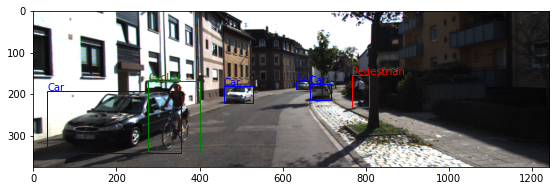

In [405]:
fig, ax = plt.subplots(1)
ax.imshow(img)

for obj in data:
    rect = patches.Rectangle((obj['bounding_box']['xmin'], obj['bounding_box']['ymin']),
                            obj['bounding_box']['xmax']-obj['bounding_box']['xmin'],
                            obj['bounding_box']['ymax']-obj['bounding_box']['ymin'],
                            linewidth=1, edgecolor=color_dict[obj['class_']], facecolor='none')
    ax.add_patch(rect)
    ax.text(obj['bounding_box']['xmin'], obj['bounding_box']['ymin'], obj['class_'], fontsize=10, color=color_dict[obj['class_']])
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()

# put the above code in a function
def plot_bounding_boxes(data):
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for obj in data:
        rect = patches.Rectangle((obj['bounding_box']['xmin'], obj['bounding_box']['ymin']),
                                obj['bounding_box']['xmax']-obj['bounding_box']['xmin'],
                                obj['bounding_box']['ymax']-obj['bounding_box']['ymin'],
                                linewidth=1, edgecolor=color_dict[obj['class_']], facecolor='none')
        ax.add_patch(rect)
        ax.text(obj['bounding_box']['xmin'], obj['bounding_box']['ymin'], obj['class_'], fontsize=10, color=color_dict[obj['class_']])
    fig.set_size_inches(18.5/2, 10.5/2)
    plt.show()

In [406]:
def intersection_over_union(box1, box2, box_format='corners'):
    if box_format == 'corners':
        box1_x1 = box1[0]
        box1_y1 = box1[1]
        box1_x2 = box1[2]
        box1_y2 = box1[3]

        box2_x1 = box2[0]
        box2_y1 = box2[1]
        box2_x2 = box2[2]
        box2_y2 = box2[3]
    else:
        raise ValueError(f"Expected box_format to be 'midpoint' or 'corners' got {box_format}")
    
    # calculate the intersection area
    inter_rect_x1 = max(box1_x1, box2_x1)
    inter_rect_y1 = max(box1_y1, box2_y1)
    inter_rect_x2 = min(box1_x2, box2_x2)
    inter_rect_y2 = min(box1_y2, box2_y2)

    # intersection area
    # inter_area = (inter_rect_x2 - inter_rect_x1) * (inter_rect_y2 - inter_rect_y1)
    inter_area = max(0, inter_rect_x2 - inter_rect_x1 + 1) * max(0, inter_rect_y2 - inter_rect_y1 + 1)
    
    # union area
    box1_area = (box1_x2 - box1_x1 + 1) * (box1_y2 - box1_y1 + 1)

    box2_area = (box2_x2 - box2_x1 + 1) * (box2_y2 - box2_y1 + 1)

    iou = inter_area / float(box1_area + box2_area - inter_area)

    # Calculate union area
    union_rect_x1 = min(box1_x1, box2_x1)
    union_rect_y1 = min(box1_y1, box2_y1)
    union_rect_x2 = max(box1_x2, box2_x2)
    union_rect_y2 = max(box1_y2, box2_y2)

    if iou > 0:
        return iou, (union_rect_x1, union_rect_y1, union_rect_x2, union_rect_y2)
    else:
        return iou, (0,0,0,0)



In [407]:
# # get all bounding boxes from data
for obj in data:
    bboxes = [obj['bounding_box']['xmin'], obj['bounding_box']['ymin'], obj['bounding_box']['xmax'], obj['bounding_box']['ymax']]
    obj['all_bounding_boxes'] = bboxes

# get the combinations of all data object ids
from itertools import combinations

object_ids = [obj['object_id'] for obj in data]

pairs = list(combinations(object_ids, 2))
ious = []
overlap = [False] * len(pairs)
overlap_bounding_boxes = []

for i, j in pairs:
    # print(data[i]['all_bounding_boxes'], data[j]['all_bounding_boxes'])
    box1 = data[i]['all_bounding_boxes']
    box2 = data[j]['all_bounding_boxes']
    iou = intersection_over_union(box1, box2)
    # print('iou:', iou[0])
    # print(type(iou[0]))
    ious.append(iou[0])

    if iou[0] > 0:
        print('overlap:', iou[0])
        overlap[pairs.index((i, j))] = True
    overlap_bounding_boxes.append(dict(zip(['xmin', 'ymin', 'xmax', 'ymax'], iou[1])))

print('overlap:', overlap)
print('pairs:', pairs)

# add the overlap to the pairs
yes_overlap = []
no_overlap = []
assert len(overlap) == len(pairs)
for i, el in enumerate(overlap):
    if el:
        yes_overlap.append(pairs[i])
    else:
        no_overlap.append(pairs[i])

print('yes_overlap:', yes_overlap)
print('no_overlap:', no_overlap)
print('overlap_bounding_boxes:', overlap_bounding_boxes)
# overlap_bounding_boxes

data

overlap: 0.20005407591443025
overlap: [True, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
yes_overlap: [(0, 1)]
no_overlap: [(0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
overlap_bounding_boxes: [{'xmin': 34.01, 'ymin': 169.09, 'xmax': 400.0, 'ymax': 340.79}, {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}, {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}, {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}, {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}, {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}, {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}, {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}, {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}, {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}, {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}, {'xmin': 0, 'ymin': 0, 'xmax': 0,

[{'object_id': 0,
  'bounding_box': {'xmin': 34.01,
   'ymin': 192.89,
   'xmax': 355.23,
   'ymax': 340.79},
  'midpoint': {'x': 194.62, 'y': 266.84000000000003},
  'class_': 'Car',
  'all_bounding_boxes': [34.01, 192.89, 355.23, 340.79]},
 {'object_id': 1,
  'bounding_box': {'xmin': 276.71,
   'ymin': 169.09,
   'xmax': 400.0,
   'ymax': 336.3},
  'midpoint': {'x': 338.355, 'y': 252.695},
  'class_': 'Cyclist',
  'all_bounding_boxes': [276.71, 169.09, 400.0, 336.3]},
 {'object_id': 2,
  'bounding_box': {'xmin': 766.76,
   'ymin': 152.44,
   'xmax': 808.56,
   'ymax': 231.74},
  'midpoint': {'x': 787.66, 'y': 192.09},
  'class_': 'Pedestrian',
  'all_bounding_boxes': [766.76, 152.44, 808.56, 231.74]},
 {'object_id': 3,
  'bounding_box': {'xmin': 457.91,
   'ymin': 181.01,
   'xmax': 529.03,
   'ymax': 220.55},
  'midpoint': {'x': 493.47, 'y': 200.78},
  'class_': 'Car',
  'all_bounding_boxes': [457.91, 181.01, 529.03, 220.55]},
 {'object_id': 4,
  'bounding_box': {'xmin': 665.58,
   '

In [408]:
# flatten yes_overlap
yes_overlap_flat = {item for sublist in yes_overlap for item in sublist}
yes_overlap_flat

for i, obj in enumerate(data):
    if obj['object_id'] in yes_overlap_flat:
        obj['overlap'] = True
    else:
        obj['overlap'] = False

In [409]:
len(yes_overlap), len(no_overlap)

(1, 14)

In [410]:
for obj in data:
    obj['plot'] = True

for tup in yes_overlap:
    print(tup)
    print(data[tup[0]]['object_id'], data[tup[0]]['all_bounding_boxes'])
    print(data[tup[1]]['object_id'], data[tup[1]]['all_bounding_boxes'])
    # these are the objects I don't want to plot, I want to plot the union of these two objects
    data[tup[0]]['plot'] = False
    data[tup[1]]['plot'] = False

# plot the objects that are not overlapping
for obj in data:
    if obj['plot']:
        print(obj['object_id'], obj['all_bounding_boxes'])

(0, 1)
0 [34.01, 192.89, 355.23, 340.79]
1 [276.71, 169.09, 400.0, 336.3]
2 [766.76, 152.44, 808.56, 231.74]
3 [457.91, 181.01, 529.03, 220.55]
4 [665.58, 175.34, 715.62, 213.93]
5 [632.36, 169.14, 663.79, 188.2]


In [411]:
from collections import defaultdict
def construct_graph(pairs):
    graph = defaultdict(list)
    for pair in pairs:
        graph[pair[0]].append(pair[1])
        graph[pair[1]].append(pair[0])
    return graph

graph = construct_graph(yes_overlap)
print(graph)

# add graph to data if graph key matches object_id
for obj in data:
    if obj['object_id'] in graph:
        obj['graph'] = graph[obj['object_id']]
    else:
        obj['graph'] = []

print(data)

defaultdict(<class 'list'>, {0: [1], 1: [0]})
[{'object_id': 0, 'bounding_box': {'xmin': 34.01, 'ymin': 192.89, 'xmax': 355.23, 'ymax': 340.79}, 'midpoint': {'x': 194.62, 'y': 266.84000000000003}, 'class_': 'Car', 'all_bounding_boxes': [34.01, 192.89, 355.23, 340.79], 'overlap': True, 'plot': False, 'graph': [1]}, {'object_id': 1, 'bounding_box': {'xmin': 276.71, 'ymin': 169.09, 'xmax': 400.0, 'ymax': 336.3}, 'midpoint': {'x': 338.355, 'y': 252.695}, 'class_': 'Cyclist', 'all_bounding_boxes': [276.71, 169.09, 400.0, 336.3], 'overlap': True, 'plot': False, 'graph': [0]}, {'object_id': 2, 'bounding_box': {'xmin': 766.76, 'ymin': 152.44, 'xmax': 808.56, 'ymax': 231.74}, 'midpoint': {'x': 787.66, 'y': 192.09}, 'class_': 'Pedestrian', 'all_bounding_boxes': [766.76, 152.44, 808.56, 231.74], 'overlap': False, 'plot': True, 'graph': []}, {'object_id': 3, 'bounding_box': {'xmin': 457.91, 'ymin': 181.01, 'xmax': 529.03, 'ymax': 220.55}, 'midpoint': {'x': 493.47, 'y': 200.78}, 'class_': 'Car', 'a

In [412]:
# flatten graph but keep associations
graph

defaultdict(list, {0: [1], 1: [0]})

In [413]:
def find_connected_components(graph):
    visited = set()
    connected_components = []
    def dfs(node):
        if node not in visited:
            visited.add(node)
            for neighbour in graph[node]:
                dfs(neighbour)
    for node in graph:
        dfs(node)
        connected_components.append(visited.copy())
        visited.clear()
    return connected_components

# print(find_connected_components(graph))
connected_objects = find_connected_components(graph)

connected_objects_1 = []
for obj in connected_objects:
    if list(obj) not in connected_objects_1:
        connected_objects_1.append(list(obj))

# print(connected_objects_1)

connected_objects = connected_objects_1

print(connected_objects)

[[0, 1]]


In [414]:
for l in connected_objects:
    print(l)

# find union of connected objects
def find_union_of_connected_objects(connected_objects, data):
    for obj in data:
        obj['last_union_bounding_box'] = False
        obj['overlap_bounding_boxes'] = {'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0}
    
    for l in connected_objects:
        xmin, ymin, xmax, ymax = 1000, 1000, 0, 0
        for i in l:
            if data[i]['bounding_box']['xmin'] < xmin:
                xmin = data[i]['bounding_box']['xmin']
            if data[i]['bounding_box']['ymin'] < ymin:
                ymin = data[i]['bounding_box']['ymin']
            if data[i]['bounding_box']['xmax'] > xmax:
                xmax = data[i]['bounding_box']['xmax']
            if data[i]['bounding_box']['ymax'] > ymax:
                ymax = data[i]['bounding_box']['ymax']
            data[i]['overlap_bounding_boxes']['xmin'], data[i]['overlap_bounding_boxes']['ymin'], data[i]['overlap_bounding_boxes']['xmax'], data[i]['overlap_bounding_boxes']['ymax'] = xmin, ymin, xmax, ymax
        # check if the last item in the list l
        # if it is, then set the last_bounding_box to True
        if i == l[-1]:
            print('last item:', i)
            data[i]['last_union_bounding_box'] = True
        
    return data

data = find_union_of_connected_objects(connected_objects, data)


[0, 1]
last item: 1


In [417]:
# if the classes of the objects that are connected are different, then don't plot the union bounding box, plot the individual bounding boxes instead
# if the classes of the objects that are connected are the same, then plot the union bounding box

# check if the classes of the objects that are connected are the same
for obj in data:
    obj['same_class'] = False

for l in connected_objects:
    classes = set()
    for i in l:
        classes.add(data[i]['class_'])
    if len(set(classes)) == 1:
        for i in l:
            data[i]['same_class'] = True

data

[{'object_id': 0,
  'bounding_box': {'xmin': 34.01,
   'ymin': 192.89,
   'xmax': 355.23,
   'ymax': 340.79},
  'midpoint': {'x': 194.62, 'y': 266.84000000000003},
  'class_': 'Car',
  'all_bounding_boxes': [34.01, 192.89, 355.23, 340.79],
  'overlap': True,
  'plot': False,
  'graph': [1],
  'last_union_bounding_box': False,
  'overlap_bounding_boxes': {'xmin': 34.01,
   'ymin': 192.89,
   'xmax': 355.23,
   'ymax': 340.79},
  'same_class': False},
 {'object_id': 1,
  'bounding_box': {'xmin': 276.71,
   'ymin': 169.09,
   'xmax': 400.0,
   'ymax': 336.3},
  'midpoint': {'x': 338.355, 'y': 252.695},
  'class_': 'Cyclist',
  'all_bounding_boxes': [276.71, 169.09, 400.0, 336.3],
  'overlap': True,
  'plot': False,
  'graph': [0],
  'last_union_bounding_box': True,
  'overlap_bounding_boxes': {'xmin': 34.01,
   'ymin': 169.09,
   'xmax': 400.0,
   'ymax': 340.79},
  'same_class': False},
 {'object_id': 2,
  'bounding_box': {'xmin': 766.76,
   'ymin': 152.44,
   'xmax': 808.56,
   'ymax': 

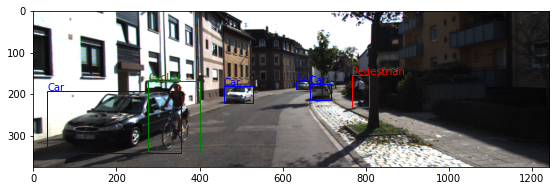

In [418]:
fig, ax = plt.subplots(1)
ax.imshow(img)

for obj in data:
    if obj['overlap'] == True and obj['last_union_bounding_box'] == True and obj['same_class'] == True:
    # if obj['overlap'] == True and obj['last_union_bounding_box'] == True:

        rect = patches.Rectangle((obj['overlap_bounding_boxes']['xmin'], obj['overlap_bounding_boxes']['ymin']),
                            obj['overlap_bounding_boxes']['xmax']-obj['overlap_bounding_boxes']['xmin'],
                            obj['overlap_bounding_boxes']['ymax']-obj['overlap_bounding_boxes']['ymin'],
                            linewidth=1, edgecolor=color_dict[obj['class_']], facecolor='none')
        ax.text(obj['overlap_bounding_boxes']['xmin'], obj['overlap_bounding_boxes']['ymin'], obj['class_'], fontsize=10, color=color_dict[obj['class_']])
        ax.add_patch(rect)
    elif obj['overlap'] == False or (obj['overlap'] == True and obj['same_class'] == False):
    # else:

        rect = patches.Rectangle((obj['bounding_box']['xmin'], obj['bounding_box']['ymin']),
                            obj['bounding_box']['xmax']-obj['bounding_box']['xmin'],
                            obj['bounding_box']['ymax']-obj['bounding_box']['ymin'],
                            linewidth=1, edgecolor=color_dict[obj['class_']], facecolor='none')
        ax.text(obj['bounding_box']['xmin'], obj['bounding_box']['ymin'], obj['class_'], fontsize=10, color=color_dict[obj['class_']])
    
        ax.add_patch(rect)
    
fig.set_size_inches(18.5/2, 10.5/2)
plt.show()

# put the above code in a function
def plot_bounding_boxes_with_unions(data):
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for obj in data:
        if obj['overlap'] == True and obj['last_union_bounding_box'] == True and obj['same_class'] == True:

            rect = patches.Rectangle((obj['overlap_bounding_boxes']['xmin'], obj['overlap_bounding_boxes']['ymin']),
                                obj['overlap_bounding_boxes']['xmax']-obj['overlap_bounding_boxes']['xmin'],
                                obj['overlap_bounding_boxes']['ymax']-obj['overlap_bounding_boxes']['ymin'],
                                linewidth=1, edgecolor=color_dict[obj['class_']], facecolor='none')
            ax.text(obj['overlap_bounding_boxes']['xmin'], obj['overlap_bounding_boxes']['ymin'], obj['class_'], fontsize=10, color=color_dict[obj['class_']])
            ax.add_patch(rect)
        elif obj['overlap'] == False or (obj['overlap'] == True and obj['same_class'] == False):
        # else:

            rect = patches.Rectangle((obj['bounding_box']['xmin'], obj['bounding_box']['ymin']),
                                obj['bounding_box']['xmax']-obj['bounding_box']['xmin'],
                                obj['bounding_box']['ymax']-obj['bounding_box']['ymin'],
                                linewidth=1, edgecolor=color_dict[obj['class_']], facecolor='none')
            ax.text(obj['bounding_box']['xmin'], obj['bounding_box']['ymin'], obj['class_'], fontsize=10, color=color_dict[obj['class_']])
        
            ax.add_patch(rect)
        
    fig.set_size_inches(18.5/2, 10.5/2)
    plt.show()

# Plot Results

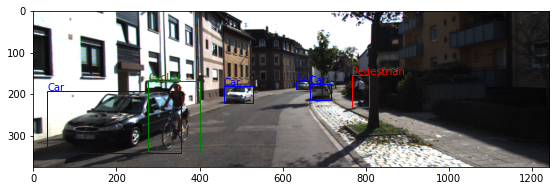

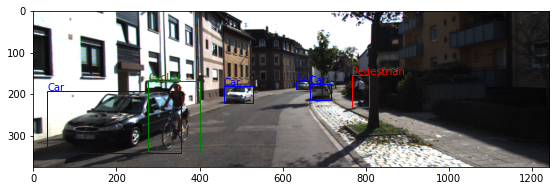

In [419]:
plot_bounding_boxes(data)
plot_bounding_boxes_with_unions(data)


## The wonderful data structure I made containing all the information on the object is in the `data` variable.

In [ ]:
data